[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AlpacaDB/jquants-api-sample/blob/main/20220915_jquantsapi_uki_predictor.ipynb)

### ※J-Quants API 有償版に対応済みです。

:# J-Quants APIを用いた財務情報発表後の高値安値予測モデル

本ノートブックでは、J-Quants API から取得したデータを用いて、J-Quantsファンダメンタルズ分析チャレンジで第2位を受賞された[UKIさんのモデル](https://github.com/UKI000/JQuants-Forum/blob/452a4f4bc086ef0a8b087efc707c51abad5ed50e/jquants01_fund_uki_predictor.py) を動かすデモとなります。

財務情報発表後の高値安値を予測するモデルとなっております。

Google Colab上で動作確認を行っています。

---

**このノートブックはGoogle Driveを使用します。**

- Google Drive の以下のフォルダーにデータを書き込みます。
    - `MyDrive/drive_ws/marketdata`
    - `MyDrive/drive_ws/models/20220915_uki_model`

## J-Quants API 利用準備: リフレッシュトークンの取得
J-Quants APIを利用するためには [J-Quants API のメニューページ](https://jpx-jquants.com/dashboard/menu/) から取得できるリフレッシュトークンが必要になります。
会員登録とリフレッシュトークンの取得を完了させてから次に進みます。

## ライブラリとデータ保存先の設定

必要なライブラリのinstall/importと設定を行います。

本ノートブックでは、J-Quants API のPythonクライアントライブラリである [jquants-api-client-python](https://github.com/J-Quants/jquants-api-client-python) を使用します。

In [4]:
# Googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')
refresh_token = ""
with open('/content/drive/MyDrive/drive_ws/jquantsapi-key') as f:
  refresh_token = f.readline().replace('\n', '')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# 必要なライブラリのインストールとインポート
!pip install scikit-learn xgboost pandas numpy jquants-api-client

# J-Quants の株式分析チュートリアルからバックテスト用ライブラリを取得します。
# !wget -q https://raw.githubusercontent.com/JapanExchangeGroup/J-Quants-Tutorial/main/handson/Chapter03/backtest/backtest.py -O backtest.py

import math
import pytz
import getpass
import io
import os
import pickle
from datetime import datetime, timedelta
from typing import List

import jquantsapi
import numpy as np
#%load_ext cudf.pandas
import pandas as pd
from matplotlib import pyplot as plt
# from backtest import Backtest
from dateutil import tz
from requests import HTTPError
from xgboost.sklearn import XGBRegressor

In [ ]:
# pandas の表示制限を調整します
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 2000)

In [ ]:
# 必要なコンフィグの定義
# Googleドライブをマウントするディレクトリ
GOOGLE_DRIVE_MOUNT_DIR_PATH = "/content/drive"
# データを保存しているGoogleドライブ上のディレクトリ
STORAGE_DIR_PATH = f"{GOOGLE_DRIVE_MOUNT_DIR_PATH}/MyDrive/drive_ws/marketdata/train"
# デバッグ中
# STORAGE_DIR_PATH = "/tmp/marketdata"
# モデルを保存しているGoogleドライブ上のディレクトリ
MODEL_DIR_PATH = f"{GOOGLE_DRIVE_MOUNT_DIR_PATH}/MyDrive/drive_ws/models"

# J-Quants API から取得するデータの期間
HISTORICAL_DATA_YEARS = 5
DAYS_IN_YESR = 365 # FIXME
today = datetime(2024,2,27)
#today = datetime.now(pytz.timezone('Asia/Tokyo'))

start_dt: datetime = today.replace(hour=23, minute=30, second=0, microsecond=0) - timedelta(days=(HISTORICAL_DATA_YEARS*365))
end_dt: datetime = today.replace(hour=23, minute=30, second=0, microsecond=0)
start_dt_yyyymmdd = start_dt.strftime("%Y%m%d")
end_dt_yyyymmdd = end_dt.strftime("%Y%m%d")

# 各種CSVデータを保存するファイルパス
# 元データ
raw_stock_list_csvfile_path = f"{STORAGE_DIR_PATH}/raw_stock_list_{start_dt_yyyymmdd}_{end_dt_yyyymmdd}.csv.gz"
raw_stock_fins_csvfile_path = f"{STORAGE_DIR_PATH}/raw_stock_fin_{start_dt_yyyymmdd}_{end_dt_yyyymmdd}.csv.gz"
raw_stock_price_csvfile_path = f"{STORAGE_DIR_PATH}/raw_stock_price_{start_dt_yyyymmdd}_{end_dt_yyyymmdd}.csv.gz"
# 処理済みデータ
stock_list_csvfile_path = f"{STORAGE_DIR_PATH}/stock_list_uki_{start_dt_yyyymmdd}_{end_dt_yyyymmdd}.csv.gz"
stock_fins_csvfile_path = f"{STORAGE_DIR_PATH}/stock_fin_uki_{start_dt_yyyymmdd}_{end_dt_yyyymmdd}.csv.gz"
stock_price_csvfile_path = f"{STORAGE_DIR_PATH}/stock_price_uki_{start_dt_yyyymmdd}_{end_dt_yyyymmdd}.csv.gz"
stock_labels_csvfile_path = f"{GOOGLE_DRIVE_MOUNT_DIR_PATH}/MyDrive/drive_ws/marketdata/stock_labels_uki_model.csv.gz"
# 生成したモデルを保存するパス
model_path = f"{MODEL_DIR_PATH}/20220915_uki_model"

# トレーニング・検証データ期間
PURGING_DAYS = 31
TRAIN_DATA_DAYS = (3 * 365) - PURGING_DAYS  # FIXME: データ期間から割合で決定する
train_start_dt: datetime = start_dt
train_end_dt: datetime = start_dt + timedelta(days=TRAIN_DATA_DAYS)

# テスト・評価期間
test_start_dt = train_end_dt + timedelta(days=PURGING_DAYS)
print("start_dt: ", start_dt)
print("end_dt: ", end_dt)
print("train_start_dt: ", train_start_dt)
print("train_end_dt: ", train_end_dt)
print("test_start_dt: ", test_start_dt)


# デバッグ中は短い期間でチェック・・・
# train_start_dt: datetime = datetime(2022, 3, 1)
# train_end_dt: datetime = datetime(2022, 6,30)
# test_start_dt: datetime = datetime(2022, 7, 1)
# test_end_dt: datetime = datetime(2022, 7, 31)
# デバッグ用の銘柄
example_codes = [7203, 9201, 6758] # toyota, jal, sony (特に銘柄選定に意味はないです)


In [ ]:
# データ保存先のフォルダーを作成しておきます
os.makedirs(STORAGE_DIR_PATH, exist_ok=True)
# モデル保存先のフォルダーを作成しておきます
os.makedirs(model_path, exist_ok=True)

## リフレッシュトークンの設定


入力ボックスに https://jpx-jquants.com/dashboard/menu/ から取得したJ-Quants APIのリフレッシュトークンを入力してください。

In [ ]:
# Googleドライブをマウント
refresh_token = ""
with open('/content/drive/MyDrive/drive_ws/jquantsapi-key') as f:
  refresh_token = f.readline().replace('\n', '')

# リフレッシュトークンを使用できるか検証します。
test_cli = jquantsapi.Client(refresh_token=refresh_token)
try:
    id_token = test_cli.get_id_token()
    if len(id_token) > 0:
        print("refresh_tokenは正常です。次の手順に進んでください。")
except HTTPError:
    print("refresh_tokenを使用できません。再度値を確認してください。")

refresh_tokenは正常です。次の手順に進んでください。


## データのダウンロードおよび保存

銘柄一覧および、上記で設定したデータ取得期間(start_dt から end_dt) の
全銘柄の価格と財務情報データを取得します。加えて、取得したデータを保存しておきます。データ処理方法を変えたりしても再度データ取得しなくて良くなります。

このステップの実行には環境によって数十分ほど時間がかかります。

In [ ]:
cli = jquantsapi.Client(refresh_token=refresh_token)
# cli = jquantsapi.Client()

# 銘柄一覧
if not os.path.isfile(raw_stock_list_csvfile_path):
    stock_list_load: pd.DataFrame = cli.get_list()
    stock_list_load.to_csv(raw_stock_list_csvfile_path, compression="gzip", index=False)
stock_list_load: pd.DataFrame = pd.read_csv(raw_stock_list_csvfile_path, dtype=str)
#data_type = stock_list_load["Code"].dtype
#print(f"The data type of 'Code': {data_type}")

# 株価情報
if not os.path.isfile(raw_stock_price_csvfile_path):
    stock_price_load: pd.DataFrame = cli.get_price_range(start_dt=start_dt, end_dt=end_dt)
    stock_price_load.to_csv(raw_stock_price_csvfile_path, compression="gzip", index=False)
stock_price_load: pd.DataFrame = pd.read_csv(raw_stock_price_csvfile_path, dtype=str)

# 財務情報
if not os.path.isfile(raw_stock_fins_csvfile_path):
    stock_fin_load: pd.DataFrame = cli.get_statements_range(start_dt=start_dt, end_dt=end_dt)
    stock_fin_load.to_csv(raw_stock_fins_csvfile_path, compression="gzip", index=False)
stock_fin_load: pd.DataFrame = pd.read_csv(raw_stock_fins_csvfile_path, dtype=str)

In [ ]:
# 上記で保存したファイルを削除するためには以下のコマンドを実行します
# 以降のセルでエラーが出た際にファイルを削除することをためしてみてください。
# os.remove(raw_stock_list_csvfile_path)
# os.remove(raw_stock_price_csvfile_path)
# os.remove(raw_stock_fins_csvfile_path)

## データ処理

過去にJ-Quants株式分析チュートリアルやデータ分析コンペティションで用いられたデータとの互換性をなるべく取るため、データの処理を行います。

In [ ]:
# 株価情報のobject型をdatetime64[ns]型に変換
stock_price_load["Date"] = pd.to_datetime(stock_price_load["Date"])

# 株価情報のいくつかがobject型になっているので数値型に変換
stock_price_load["AdjustmentOpen"] = stock_price_load["AdjustmentOpen"].astype(np.float64)
stock_price_load["AdjustmentHigh"] = stock_price_load["AdjustmentHigh"].astype(np.float64)
stock_price_load["AdjustmentLow"] = stock_price_load["AdjustmentLow"].astype(np.float64)
stock_price_load["AdjustmentClose"] = stock_price_load["AdjustmentClose"].astype(np.float64)
stock_price_load["AdjustmentFactor"] = stock_price_load["AdjustmentFactor"].astype(np.float64)
stock_price_load["TurnoverValue"] = stock_price_load["TurnoverValue"].astype(np.float64)

# 累積調整係数を作成します
def generate_cumulative_adjustment_factor(df):
   # 分割併合等の係数を適用日に変更
   df.loc[:, "AdjustmentFactor"] = df["AdjustmentFactor"].shift(-1).fillna(1.0)

   # 調整係数を作成するために逆順にソートする
   df = df.sort_values("Date", ascending=False)
   # 累積株価調整係数を作成
   df.loc[:, "EndOfDayQuote CumulativeAdjustmentFactor"] = 1 / df["AdjustmentFactor"].cumprod()
   # ソート順を昇順にする
   df = df.sort_values("Date")

   return df
# 累積調整係数を追加
stock_price_load = stock_price_load.sort_values(["Code", "Date"])
stock_price_load = stock_price_load.groupby("Code", group_keys=False).apply(generate_cumulative_adjustment_factor).reset_index(drop=True)

# 普通株 (5桁で末尾が0) の銘柄コードを4桁にします
stock_price_load.loc[(stock_price_load["Code"].str.len() == 5) & (stock_price_load["Code"].str[-1] == "0"), "Code"] = stock_price_load.loc[(stock_price_load["Code"].str.len() == 5) & (stock_price_load["Code"].str[-1] == "0"), "Code"].str[:-1]


In [ ]:
# 財務情報のいくつかがobject型になっているので数値型に変換
numeric_cols_fin = ['AverageNumberOfShares', 'BookValuePerShare', 'EarningsPerShare','Equity', 'EquityToAssetRatio',
                'ForecastDividendPerShare1stQuarter', 'ForecastDividendPerShare2ndQuarter', 'ForecastDividendPerShare3rdQuarter',
                'ForecastDividendPerShareAnnual', 'ForecastDividendPerShareFiscalYearEnd', 'ForecastEarningsPerShare', 'ForecastNetSales', 'ForecastOperatingProfit',
                'ForecastOrdinaryProfit', 'ForecastProfit', 'NetSales', 'NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock',
                'OperatingProfit', 'OrdinaryProfit', 'Profit', 'ResultDividendPerShare1stQuarter','ResultDividendPerShare2ndQuarter','ResultDividendPerShare3rdQuarter',
                'ResultDividendPerShareAnnual','ResultDividendPerShareFiscalYearEnd','TotalAssets']
stock_fin_load[numeric_cols_fin] = stock_fin_load[numeric_cols_fin].apply(pd.to_numeric, errors='coerce', axis=1)

# 財務情報のobject型をdatetime64[ns]型に変換
stock_fin_load["DisclosedDate"] = pd.to_datetime(stock_fin_load["DisclosedDate"]) #開示
stock_fin_load["CurrentFiscalYearEndDate"] = pd.to_datetime(stock_fin_load["CurrentFiscalYearEndDate"])  # 当事業年度終了日
stock_fin_load["CurrentFiscalYearStartDate"] = pd.to_datetime(stock_fin_load["CurrentFiscalYearStartDate"])  # 当事業年度開始日
stock_fin_load["CurrentPeriodEndDate"] = pd.to_datetime(stock_fin_load["CurrentPeriodEndDate"]) # 当会計期間終了日

# 財務情報の値を調整します
stock_fin_load["Result_FinancialStatement FiscalYear"] = stock_fin_load["CurrentFiscalYearEndDate"].dt.strftime("%Y")

# 財務情報の同一日に複数レコードが存在することに対応します。
# ある銘柄について同一日に複数の開示が行われた場合レコードが重複します。
# ここでは簡易的に処理するために特定のTypeOfDocumentを削除した後に、開示時間順に並べて一番最後に発表された開示情報を採用しています。
stock_fin_load = stock_fin_load.loc[~stock_fin_load["TypeOfDocument"].isin(["ForecastRevision", "NumericalCorrection", "ForecastRevision_REIT"])]
stock_fin_load = stock_fin_load.sort_values(["DisclosedDate", "DisclosedTime"]).drop_duplicates(subset=["LocalCode", "DisclosedDate"], keep="last")

# 普通株 (5桁で末尾が0) の銘柄コードを4桁にします
stock_fin_load.loc[(stock_fin_load["LocalCode"].str.len() == 5) & (stock_fin_load["LocalCode"].str[-1] == "0"), "LocalCode"] = stock_fin_load.loc[(stock_fin_load["LocalCode"].str.len() == 5) & (stock_fin_load["LocalCode"].str[-1] == "0"), "LocalCode"].str[:-1]


In [ ]:
# 銘柄一覧
# 普通株 (5桁で末尾が0) の銘柄コードを4桁にします
stock_list_load.loc[(stock_list_load["Code"].str.len() == 5) & (stock_list_load["Code"].str[-1] == "0"), "Code"] = stock_list_load.loc[(stock_list_load["Code"].str.len() == 5) & (stock_list_load["Code"].str[-1] == "0"), "Code"].str[:-1]

# 銘柄一覧と株価データから予測対象列を作成します

# prediction_target
# プライム(111)の500位～1000位の銘柄を選択
prime_targets = (stock_price_load.loc[
    (stock_price_load["Date"] >= "2022-01-01") &
    (stock_price_load["Code"].isin(stock_list_load.loc[stock_list_load["MarketCode"] == "0111", "Code"])),
    ["Code", "TurnoverValue"]
].groupby("Code").sum()).sort_values("TurnoverValue", ascending=False)[500:1000].index

# スタンダード(112)の500位～1000位の銘柄を選択
standard_targets = (stock_price_load.loc[
    (stock_price_load["Date"] >= "2022-01-01") &
    (stock_price_load["Code"].isin(stock_list_load.loc[stock_list_load["MarketCode"] == "0112", "Code"])),
    ["Code", "TurnoverValue"]
].groupby("Code").sum()).sort_values("TurnoverValue", ascending=False)[500:1000].index
# グロース株すべて
growth_targets = stock_list_load.loc[stock_list_load["MarketCode"] == "0113", "Code"]

prime_targets = pd.Index(prime_targets)
standard_targets = pd.Index(standard_targets)
growth_targets = pd.Index(growth_targets)
pred_targets = prime_targets.union(standard_targets).union(growth_targets)

target_list = stock_list_load.loc[stock_list_load["MarketCode"].isin(["0111", "0112", "0113"]), "Code"]


# prediction_target = プライム(111)、スタンダード(112)、グロース(113)の 2022-01-01 以降の売買代金上位2000銘柄
#target_list = stock_list_load.loc[stock_list_load["MarketCode"].isin(["0111", "0112", "0113"]), "Code"]
#pred_targets = (stock_price_load.loc[(stock_price_load["Date"] >= "2022-01-01") & (stock_price_load["Code"].isin(target_list)), ["Code", "TurnoverValue"]].groupby("Code").sum()).sort_values("TurnoverValue", ascending=False).head(2000).index

stock_list_load["prediction_target"] = stock_list_load["Code"].isin(pred_targets)
# universe_comp2 は、プライム、スタンダード、グロースのデータの最新日付時点の時価総額上位2000銘柄とします
latest_date = pd.to_datetime(sorted(stock_price_load["Date"].unique())[-1]).strftime("%Y-%m-%d")
df_atp = stock_price_load.loc[stock_price_load["Date"] == str(latest_date), ["Code", "AdjustmentClose"]]
df_atp = df_atp.loc[df_atp["Code"].isin(target_list)]
def _nos(df):
    df = df.sort_values(["DisclosedDate", "DisclosedTime"])
    df = df.ffill()
    df = df.tail(1)
    return df
df_nos = stock_fin_load.groupby("LocalCode")[["DisclosedDate", "DisclosedTime", "NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock"]].apply(_nos)
df_nos = df_nos.reset_index()
df_mcap = pd.merge(df_atp, df_nos, left_on=["Code"], right_on=["LocalCode"], how="inner")
df_mcap["mcap"] = df_mcap["AdjustmentClose"] * df_mcap["NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock"]
universe_comp2 = sorted(df_mcap.sort_values("mcap").tail(2000)["Code"])
stock_list_load["universe_comp2"] = stock_list_load["Code"].isin(universe_comp2)


In [ ]:
# stock_list: データの互換性のための各種列名変換など
stock_list: pd.DataFrame = pd.DataFrame()
stock_list["Local Code"] = stock_list_load["Code"]

stock_list["Name (English)"] = stock_list_load["CompanyName"]  # 英語名の代わりに日本語名を設定
stock_list["Section/Products"] = stock_list_load["MarketCodeName"]
stock_list["33 Sector(Code)"] = stock_list_load["Sector33Code"]
stock_list["33 Sector(Name)"] = stock_list_load["Sector33CodeName"]
stock_list["17 Sector(Code)"] = stock_list_load["Sector17Code"]
stock_list["17 Sector(Name)"] = stock_list_load["Sector17CodeName"]
stock_list["Size (New Index Series)"] = stock_list_load["ScaleCategory"]
stock_list["prediction_target"] = stock_list_load["prediction_target"]
stock_list["universe_comp2"] = stock_list_load["universe_comp2"]


In [ ]:
# stock_price: データの互換性のための各種列名変換など
stock_price: pd.DataFrame = pd.DataFrame()
stock_price["Local Code"] = stock_price_load["Code"]
#stock_price["Date"] = stock_price_load["Date"]
stock_price["base_date"] = stock_price_load["Date"]
stock_price['EndOfDayQuote Date'] = stock_price_load["Date"]
stock_price["EndOfDayQuote Open"] = stock_price_load["AdjustmentOpen"]
stock_price["EndOfDayQuote High"] = stock_price_load["AdjustmentHigh"]
stock_price["EndOfDayQuote Low"] = stock_price_load["AdjustmentLow"]
stock_price["EndOfDayQuote Close"] = stock_price_load["AdjustmentClose"]
stock_price["EndOfDayQuote ExchangeOfficialClose"] = stock_price_load["AdjustmentClose"]
stock_price["EndOfDayQuote Volume"] = stock_price_load["AdjustmentVolume"]
stock_price["EndOfDayQuote CumulativeAdjustmentFactor"] = stock_price_load["EndOfDayQuote CumulativeAdjustmentFactor"]

stock_price.sort_values(["Local Code", "base_date"], inplace=True)
# ExchangeOfficialClose は欠損値がある場合は前日終値とします
stock_price["EndOfDayQuote ExchangeOfficialClose"] = stock_price.groupby(["Local Code"])["EndOfDayQuote ExchangeOfficialClose"].ffill()
# 前日終値の列を終値列から作成
stock_price["EndOfDayQuote PreviousClose"] = stock_price.groupby(["Local Code"])["EndOfDayQuote Close"].shift(1)
#stock_price.head()
stock_price.tail()

,Local Code,base_date,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose
5038415,9997,2024-02-20,2024-02-20,619.0,619.0,614.0,616.0,616.0,218200.0,1.0,618.0
5038416,9997,2024-02-21,2024-02-21,615.0,616.0,613.0,615.0,615.0,194900.0,1.0,616.0
5038417,9997,2024-02-22,2024-02-22,615.0,618.0,612.0,613.0,613.0,246900.0,1.0,615.0
5038418,9997,2024-02-26,2024-02-26,615.0,620.0,615.0,618.0,618.0,244600.0,1.0,613.0
5038419,9997,2024-02-27,2024-02-27,618.0,623.0,617.0,619.0,619.0,265100.0,1.0,618.0


In [ ]:
# stock_financial: データの互換性のための各種列名変換など
stock_fin: pd.DataFrame = pd.DataFrame()
stock_fin["Local Code"] = stock_fin_load["LocalCode"]
stock_fin["Result_FinancialStatement FiscalPeriodEnd"] = stock_fin_load["CurrentPeriodEndDate"].dt.strftime("%Y/%m")
stock_fin["Result_FinancialStatement TotalAssets"] = stock_fin_load["TotalAssets"] # 総資産
stock_fin["Result_FinancialStatement NetAssets"] = stock_fin_load["Equity"] # 純資産
stock_fin["Result_FinancialStatement NetSales"] = stock_fin_load["NetSales"] # 純売上高
stock_fin["Result_FinancialStatement OperatingIncome"] = stock_fin_load["OperatingProfit"] # 営業利益
stock_fin["Result_FinancialStatement OrdinaryIncome"] = stock_fin_load["OrdinaryProfit"]  # 経常利益
stock_fin["Result_FinancialStatement NetIncome"] = stock_fin_load["Profit"]  # 当期純利益
stock_fin["Result_FinancialStatement ReportType"] = stock_fin_load["TypeOfCurrentPeriod"] # {"1Q", "2Q", "3Q", "FY"}
stock_fin["Result_FinancialStatement FiscalYear"] = stock_fin_load["Result_FinancialStatement FiscalYear"]
stock_fin["base_date"] = stock_fin_load["DisclosedDate"] # 開示日
stock_fin["TypeOfDocument"] = stock_fin_load["TypeOfDocument"] # 書類種別
stock_fin["RetrospectiveRestatement"] = stock_fin_load["RetrospectiveRestatement"] #修正再表示フラグ
stock_fin["Forecast_FinancialStatement FiscalPeriodEnd"] = stock_fin_load["CurrentFiscalYearEndDate"].dt.strftime("%Y/%m")
stock_fin.loc[stock_fin["Result_FinancialStatement ReportType"] == "FY", "Forecast_FinancialStatement FiscalPeriodEnd"] = (
    stock_fin_load["CurrentFiscalYearEndDate"] + pd.Timedelta(365, unit="D")
).dt.strftime("%Y/%m")  # 本決算の場合は次の年度予想なので1年後の日付にします
stock_fin["Forecast_FinancialStatement ReportType"] = "FY"  #  予想は通期固定
stock_fin["Forecast_FinancialStatement NetSales"] = stock_fin_load["ForecastNetSales"]
stock_fin["Forecast_FinancialStatement OperatingIncome"] = stock_fin_load["ForecastOperatingProfit"]
stock_fin["Forecast_FinancialStatement NetIncome"] = stock_fin_load["ForecastProfit"]
stock_fin["Forecast_FinancialStatement OrdinaryIncome"] = stock_fin_load["ForecastOrdinaryProfit"]

#stock_fin.head()
stock_fin.tail()

,Local Code,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,base_date,TypeOfDocument,RetrospectiveRestatement,Forecast_FinancialStatement FiscalPeriodEnd,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement NetIncome,Forecast_FinancialStatement OrdinaryIncome
96259,1960,2024/03,NaN,NaN,NaN,NaN,NaN,NaN,FY,2024,2024-02-26,EarnForecastRevision,NaN,2025/03,FY,5.000000e+10,-800000000.0,260000000.0,-100000000.0
96260,8894,2024/04,NaN,NaN,NaN,NaN,NaN,NaN,2Q,2024,2024-02-26,EarnForecastRevision,NaN,2024/10,FY,5.021000e+09,373000000.0,373000000.0,388000000.0
96261,3490,2024/02,NaN,NaN,NaN,NaN,NaN,NaN,FY,2024,2024-02-26,EarnForecastRevision,NaN,2025/02,FY,1.149500e+10,655000000.0,624000000.0,445000000.0
96263,3802,2024/03,NaN,NaN,NaN,NaN,NaN,NaN,FY,2024,2024-02-26,DividendForecastRevision,NaN,2025/03,FY,NaN,NaN,NaN,NaN
96264,4053,2023/12,1.185900e+10,9.499000e+09,1.251600e+10,1.775000e+09,2.279000e+09,1.569000e+09,FY,2023,2024-02-26,FYFinancialStatements_Consolidated_JP,false,2024/12,FY,NaN,NaN,NaN,NaN


目的変数を作成します。40分程度かかります。

In [ ]:
def create_label_high_low(stock_code:int, target_date:datetime, lookaheads:List[int], stock_price:pd.DataFrame):
   #memo: 例えばtarget_dateが2022-08-01, lookaheads=[1,5,10]だった場合、stock_priceは2022-08-01より10営業日先のデータまではいってないといけない

   #df_price = stock_price.loc[(stock_price["Local Code"] == stock_code) & (stock_price["base_date"] <= target_date)].copy()
   df_price = stock_price.loc[stock_price["Local Code"] == stock_code].copy()

   output_columns = ["base_date", "Local Code"]
   for lookahead in lookaheads:
       output_columns.append("label_date_{}".format(lookahead))
       output_columns.append("label_high_{}".format(lookahead))
       output_columns.append("label_low_{}".format(lookahead))
       t_col = "label_date_{}".format(lookahead)
       df_price.loc[:, t_col] = df_price.loc[:, "base_date"].shift(-lookahead)

   if len(df_price) == 0:
       return pd.DataFrame(None, columns=output_columns)

   for lookahead in lookaheads:
       # df_high_high: base_dateからn営業日の間の高値の最大値
       df_high_high = df_price.loc[:, "EndOfDayQuote High"].rolling(lookahead, min_periods=1).max()
       df_high_high = df_high_high.shift(-lookahead)
       df_high_high_diff = df_high_high - df_price.loc[:, "EndOfDayQuote ExchangeOfficialClose"]
       df_price.loc[:, "label_high_{}".format(lookahead)] = df_high_high_diff / df_price.loc[:, "EndOfDayQuote ExchangeOfficialClose"]

       # df_low_low: base_dateからn営業日の間の安値の最小値
       df_low_low = df_price.loc[:, "EndOfDayQuote Low"].rolling(lookahead, min_periods=1).min()
       df_low_low = df_low_low.shift(-lookahead)
       df_low_low_diff = df_low_low - df_price.loc[:, "EndOfDayQuote ExchangeOfficialClose"]
       df_price.loc[:, "label_low_{}".format(lookahead)] = df_low_low_diff / df_price.loc[:, "EndOfDayQuote ExchangeOfficialClose"]

   df_price.replace(np.inf, np.nan, inplace=True)
   df_price = df_price[df_price["base_date"] <= target_date]
   return df_price.loc[:, output_columns]

def create_delivery_label_high_low(stock_codes:List[int], target_date:pd.Timestamp, lookaheads:List[int], stock_price:pd.DataFrame):
   buff = []
   for stock_code in stock_codes:
       df = create_label_high_low(stock_code, target_date, lookaheads, stock_price)
       buff.append(df)
   df_labels = pd.concat(buff)
   return df_labels

def output_stock_labels(stock_labels_csvfile_path:str, df_labels:pd.DataFrame, output_start_dt, end_dt:datetime):
   df_labels = df_labels.set_index("base_date")
   df_labels = df_labels.loc[df_labels.index <= end_dt].copy()
   df_labels.index.name = "base_date"
   df_labels_output = df_labels.loc[(df_labels.index >= output_start_dt) & (df_labels.index <= end_dt)]
   label_output_columns = [
       "Local Code",
       "label_date_5",
       "label_high_5",
       "label_low_5",
       "label_date_10",
       "label_high_10",
       "label_low_10",
       "label_date_20",
       "label_high_20",
       "label_low_20",
   ]
   df_labels_output.to_csv(stock_labels_csvfile_path, compression="gzip", float_format="%.5f", columns=label_output_columns)

stock_codes = sorted(stock_price["Local Code"].unique())

lookaheads = [5, 10, 20]
stock_labels = create_delivery_label_high_low(stock_codes, end_dt, lookaheads, stock_price)

## GoogleDriveへのCSV保存

取得したデータをcsv.gz形式で保存します。
stock_priceおよびstock_listが巨大なファイル（非圧縮, 2017-01-01〜2022-07-31の期間だと540MB程度)なので、保存には10分ほどかかることがあります。

In [ ]:
stock_list.to_csv(stock_list_csvfile_path, compression="gzip", index=False)
stock_price.to_csv(stock_price_csvfile_path, compression="gzip", index=False)
stock_fin.to_csv(stock_fins_csvfile_path, compression="gzip", index=False)
output_stock_labels(stock_labels_csvfile_path, stock_labels, start_dt, end_dt)

## データセットの読み込み

事前に生成しておいたcsvデータを読み込みます。

In [ ]:
# ノートブックの冪等性を高めるためこれらの変数はこのセル以外でいじらない
stock_list:pd.DataFrame = pd.read_csv(stock_list_csvfile_path, dtype={"Local Code": str})
stock_price:pd.DataFrame = pd.read_csv(stock_price_csvfile_path, dtype={"Local Code": str})
stock_fin:pd.DataFrame = pd.read_csv(stock_fins_csvfile_path, dtype={"Local Code": str})
stock_labels:pd.DataFrame = pd.read_csv(stock_labels_csvfile_path, dtype={"Local Code": str})
#data_type = stock_list["Local Code"].dtype
#print(f"The data type of 'Local Code': {data_type}")


# object型をdatetime64[ns]型に変換
stock_price["base_date"] = pd.to_datetime(stock_price["base_date"])
stock_price["EndOfDayQuote Date"] = pd.to_datetime(stock_price["EndOfDayQuote Date"])
stock_fin["base_date"] = pd.to_datetime(stock_fin["base_date"])
stock_fin["Result_FinancialStatement FiscalPeriodEnd"] = pd.to_datetime(stock_fin["Result_FinancialStatement FiscalPeriodEnd"])
stock_fin["Forecast_FinancialStatement FiscalPeriodEnd"] = pd.to_datetime(stock_fin["Forecast_FinancialStatement FiscalPeriodEnd"])
stock_labels["base_date"] = pd.to_datetime(stock_labels["base_date"])

# Unnamedな列を削除しておく
stock_price = stock_price.loc[:, ~stock_price.columns.str.contains('^Unnamed')]
stock_fin = stock_fin.loc[:, ~stock_fin.columns.str.contains('^Unnamed')]

#stock_fin.fillna(0)
print("stock_fin date range:", stock_fin['base_date'].min(), "to", stock_fin['base_date'].max())

stock_fin date range: 2019-02-28 00:00:00 to 2024-02-26 00:00:00


In [ ]:
stock_list.tail(2)

,Local Code,Name (English),Section/Products,33 Sector(Code),33 Sector(Name),17 Sector(Code),17 Sector(Name),Size (New Index Series),prediction_target,universe_comp2
4338,9996,サトー商会,スタンダード,6050,卸売業,13,商社・卸売,-,False,True
4339,9997,ベルーナ,プライム,6100,小売業,14,小売,TOPIX Small 1,False,True


In [ ]:
stock_price.tail(2)

,Local Code,base_date,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose
5038418,9997,2024-02-26,2024-02-26,615.0,620.0,615.0,618.0,618.0,244600.0,1.0,613.0
5038419,9997,2024-02-27,2024-02-27,618.0,623.0,617.0,619.0,619.0,265100.0,1.0,618.0


In [ ]:
stock_fin.tail(2)

,Local Code,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,base_date,TypeOfDocument,RetrospectiveRestatement,Forecast_FinancialStatement FiscalPeriodEnd,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement NetIncome,Forecast_FinancialStatement OrdinaryIncome
91132,3802,2024-03-01,NaN,NaN,NaN,NaN,NaN,NaN,FY,2024,2024-02-26,DividendForecastRevision,NaN,2025-03-01,FY,NaN,NaN,NaN,NaN
91133,4053,2023-12-01,1.185900e+10,9.499000e+09,1.251600e+10,1.775000e+09,2.279000e+09,1.569000e+09,FY,2023,2024-02-26,FYFinancialStatements_Consolidated_JP,False,2024-12-01,FY,NaN,NaN,NaN,NaN


In [ ]:
stock_labels.tail(2)

,base_date,Local Code,label_date_5,label_high_5,label_low_5,label_date_10,label_high_10,label_low_10,label_date_20,label_high_20,label_low_20
5038418,2024-02-26,9997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5038419,2024-02-27,9997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## モデルの作成と保存

特徴量と目的変数を生成し、学習を行います。

In [ ]:
stock_codes = sorted(stock_price["Local Code"].unique())


生成した特徴量とラベルデータを用いて学習を行います。

## モデル作成 & 推論実行

モデル作成 & predictを行います。5年分で40分程度

In [ ]:
# stock_priceを使ったテクニカル指標を各銘柄ごとに計算
def get_technical(stock_price:pd.DataFrame, code:int)->pd.DataFrame:
    technical_df = stock_price[stock_price["Local Code"] == code].copy()
    # 終値
    technical_df["close"] = technical_df["EndOfDayQuote Close"]
    # 騰落率
    technical_df["ror_1"] = technical_df["EndOfDayQuote Close"].pct_change(1)
    technical_df["ror_5"] = technical_df["EndOfDayQuote Close"].pct_change(5) # 5営業日前からの終値の変化率
    technical_df["ror_10"] = technical_df["EndOfDayQuote Close"].pct_change(10)
    technical_df["ror_20"] = technical_df["EndOfDayQuote Close"].pct_change(20)
    technical_df["ror_40"] = technical_df["EndOfDayQuote Close"].pct_change(40)
    technical_df["ror_60"] = technical_df["EndOfDayQuote Close"].pct_change(60)
    technical_df["ror_100"] = technical_df["EndOfDayQuote Close"].pct_change(100)

    # 売買代金
    technical_df["volume"] = technical_df["EndOfDayQuote Close"] * technical_df["EndOfDayQuote Volume"]
    technical_df = technical_df.replace([np.inf, -np.inf], np.nan)

    technical_df["vol_1"] = technical_df["volume"]
    technical_df["vol_5"] = technical_df["volume"].rolling(5).mean() # 5日移動平均
    technical_df["vol_10"] = technical_df["volume"].rolling(10).mean()
    technical_df["vol_20"] = technical_df["volume"].rolling(20).mean()
    technical_df["vol_40"] = technical_df["volume"].rolling(40).mean()
    technical_df["vol_60"] = technical_df["volume"].rolling(60).mean()
    technical_df["vol_100"] = technical_df["volume"].rolling(100).mean()
    technical_df["d_vol"] = technical_df["volume"] / technical_df["vol_20"]

    # レンジ (前日の終値に対して何%値動きしたか)
    technical_df["range"] = (
        technical_df[["EndOfDayQuote PreviousClose", "EndOfDayQuote High"]].max(axis=1)
        - technical_df[["EndOfDayQuote PreviousClose", "EndOfDayQuote Low"]].min(axis=1)
        ) / technical_df["EndOfDayQuote PreviousClose"]
    technical_df = technical_df.replace([np.inf, -np.inf], np.nan)

    # レンジの移動平均
    technical_df["atr_1"] = technical_df["range"]
    technical_df["atr_5"] = technical_df["range"].rolling(5).mean()
    technical_df["atr_10"] = technical_df["range"].rolling(10).mean()
    technical_df["atr_20"] = technical_df["range"].rolling(20).mean()
    technical_df["atr_40"] = technical_df["range"].rolling(40).mean()
    technical_df["atr_60"] = technical_df["range"].rolling(60).mean()
    technical_df["atr_100"] = technical_df["range"].rolling(100).mean()
    technical_df["d_atr"] = technical_df["range"] / technical_df["atr_20"]

    # ギャップ (前日の終値よりも当日の始値がどれだけ値動きしたか) のレンジ
    technical_df["gap_range"] = (np.abs(technical_df["EndOfDayQuote Open"] - technical_df["EndOfDayQuote PreviousClose"])) / technical_df[
        "EndOfDayQuote PreviousClose"]
    technical_df["g_atr_1"] = technical_df["gap_range"]
    technical_df["g_atr_5"] = technical_df["gap_range"].rolling(5).mean()
    technical_df["g_atr_10"] = technical_df["gap_range"].rolling(10).mean()
    technical_df["g_atr_20"] = technical_df["gap_range"].rolling(20).mean()
    technical_df["g_atr_40"] = technical_df["gap_range"].rolling(40).mean()
    technical_df["g_atr_60"] = technical_df["gap_range"].rolling(60).mean()
    technical_df["g_atr_100"] = technical_df["gap_range"].rolling(100).mean()

    # デイレンジ
    technical_df["day_range"] = (technical_df["EndOfDayQuote High"] - technical_df["EndOfDayQuote Low"]) / technical_df[
        "EndOfDayQuote PreviousClose"]
    technical_df["d_atr_1"] = technical_df["day_range"]
    technical_df["d_atr_5"] = technical_df["day_range"].rolling(5).mean()
    technical_df["d_atr_10"] = technical_df["day_range"].rolling(10).mean()
    technical_df["d_atr_20"] = technical_df["day_range"].rolling(20).mean()
    technical_df["d_atr_40"] = technical_df["day_range"].rolling(40).mean()
    technical_df["d_atr_60"] = technical_df["day_range"].rolling(60).mean()
    technical_df["d_atr_100"] = technical_df["day_range"].rolling(100).mean()

    # ヒゲレンジ: ((高値-低値) - (始値と終値の差))/終値
    technical_df["hig_range"] = ((technical_df["EndOfDayQuote High"] - technical_df["EndOfDayQuote Low"]) - np.abs(
        technical_df["EndOfDayQuote Open"] - technical_df["EndOfDayQuote Close"])) / technical_df["EndOfDayQuote PreviousClose"]
    technical_df["h_atr_1"] = technical_df["hig_range"]
    technical_df["h_atr_5"] = technical_df["hig_range"].rolling(5).mean()
    technical_df["h_atr_10"] = technical_df["hig_range"].rolling(10).mean()
    technical_df["h_atr_20"] = technical_df["hig_range"].rolling(20).mean()
    technical_df["h_atr_40"] = technical_df["hig_range"].rolling(40).mean()
    technical_df["h_atr_60"] = technical_df["hig_range"].rolling(60).mean()
    technical_df["h_atr_100"] = technical_df["hig_range"].rolling(100).mean()

    # ボラティリティ
    technical_df["vola_5"] = technical_df["ror_1"].rolling(5).std()
    technical_df["vola_10"] = technical_df["ror_1"].rolling(10).std()
    technical_df["vola_20"] = technical_df["ror_1"].rolling(20).std()
    technical_df["vola_40"] = technical_df["ror_1"].rolling(40).std()
    technical_df["vola_60"] = technical_df["ror_1"].rolling(60).std()
    technical_df["vola_100"] = technical_df["ror_1"].rolling(100).std()

    # HL(High-Low)バンド: 直近n日の高値（Hバンド）、安値（Lバンド）
    technical_df["hl_5"] = technical_df["EndOfDayQuote High"].rolling(5).max() - technical_df["EndOfDayQuote Low"].rolling(5).min()
    technical_df["hl_10"] = technical_df["EndOfDayQuote High"].rolling(10).max() - technical_df["EndOfDayQuote Low"].rolling(10).min()
    technical_df["hl_20"] = technical_df["EndOfDayQuote High"].rolling(20).max() - technical_df["EndOfDayQuote Low"].rolling(20).min()
    technical_df["hl_40"] = technical_df["EndOfDayQuote High"].rolling(40).max() - technical_df["EndOfDayQuote Low"].rolling(40).min()
    technical_df["hl_60"] = technical_df["EndOfDayQuote High"].rolling(60).max() - technical_df["EndOfDayQuote Low"].rolling(60).min()
    technical_df["hl_100"] = technical_df["EndOfDayQuote High"].rolling(100).max() - technical_df["EndOfDayQuote Low"].rolling(100).min()

    # マーケットインパクト
    technical_df["mi"] = technical_df["range"] / (technical_df["EndOfDayQuote Volume"] * technical_df["EndOfDayQuote Close"])
    technical_df = technical_df.replace([np.inf, -np.inf], np.nan) # "EndOfDayQuote Volume"=0の場合への考慮

    technical_df["mi_5"] = technical_df["mi"].rolling(5).mean()
    technical_df["mi_10"] = technical_df["mi"].rolling(10).mean()
    technical_df["mi_20"] = technical_df["mi"].rolling(20).mean()
    technical_df["mi_40"] = technical_df["mi"].rolling(40).mean()
    technical_df["mi_60"] = technical_df["mi"].rolling(60).mean()
    technical_df["mi_100"] = technical_df["mi"].rolling(100).mean()

    feat = ["EndOfDayQuote Date", "Local Code", "close",
            "ror_1", "ror_5", "ror_10", "ror_20", "ror_40", "ror_60", "ror_100",
            "vol_1", "vol_5", "vol_10", "vol_20", "vol_40", "vol_60", "vol_100", "d_vol",
            "atr_1", "atr_5", "atr_10", "atr_20", "atr_40", "atr_60", "atr_100", "d_atr",
            "g_atr_1", "g_atr_5", "g_atr_10", "g_atr_20", "g_atr_40", "g_atr_60", "g_atr_100",
            "d_atr_1", "d_atr_5", "d_atr_10", "d_atr_20", "d_atr_40", "d_atr_60", "d_atr_100",
            "h_atr_1", "h_atr_5", "h_atr_10", "h_atr_20", "h_atr_40", "h_atr_60", "h_atr_100",
            "vola_5", "vola_10", "vola_20", "vola_40", "vola_60", "vola_100",
            "hl_5", "hl_10", "hl_20", "hl_40", "hl_60", "hl_100",
            "mi_5", "mi_10", "mi_20", "mi_40", "mi_60", "mi_100"]
    technical_df = technical_df[feat]
    technical_df.columns = ["datetime", "code", "close",
                      "ror_1", "ror_5", "ror_10", "ror_20", "ror_40", "ror_60", "ror_100",
                      "vol_1", "vol_5", "vol_10", "vol_20", "vol_40", "vol_60", "vol_100", "d_vol",
                      "atr_1", "atr_5", "atr_10", "atr_20", "atr_40", "atr_60", "atr_100", "d_atr",
                      "g_atr_1", "g_atr_5", "g_atr_10", "g_atr_20", "g_atr_40", "g_atr_60", "g_atr_100",
                      "d_atr_1", "d_atr_5", "d_atr_10", "d_atr_20", "d_atr_40", "d_atr_60", "d_atr_100",
                      "h_atr_1", "h_atr_5", "h_atr_10", "h_atr_20", "h_atr_40", "h_atr_60", "h_atr_100",
                      "vola_5", "vola_10", "vola_20", "vola_40", "vola_60", "vola_100",
                      "hl_5", "hl_10", "hl_20", "hl_40", "hl_60", "hl_100",
                      "mi_5", "mi_10", "mi_20", "mi_40", "mi_60", "mi_100"]
    technical_df["datetime"] = pd.to_datetime(technical_df["datetime"])
    technical_df = technical_df.set_index(["datetime", "code"])
    return technical_df

# example
# get_technical(stock_price, example_codes[0]).tail()



# stock_finを使った指標を各銘柄ごとに計算
def get_financial(stock_fin:pd.DataFrame, code:int)->pd.DataFrame:

    fin_df = stock_fin[stock_fin["Local Code"] == code].copy()

    #print("get_financial() fin_df date range:", code, fin_df['base_date'].min(), "to", fin_df['base_date'].max())
    #print("get_financial() stock_fin date range:", code, stock_fin['base_date'].min(), "to", stock_fin['base_date'].max())

    # TypeOfDocumentの値によってはTotalAssetsなどの値がNaNになっているのでffill
    fin_df = fin_df.ffill()

    # --- 本決算／中間決算フラグ、修正開示フラグ、事後修正有無フラグ ---
    fin_df["annual"] = 0 # 0: 中間決算, 1:本決算
    fin_df["revision"] = 0 # 1: 修正再表示
    # FYFinancialStatements*** は本決算
    fin_df.loc[fin_df["TypeOfDocument"].isin(["FYFinancialStatements_Consolidated_JP", "FYFinancialStatements_Consolidated_US", "FYFinancialStatements_Consolidated_IFRS"]), "annual"] = 1
    fin_df.loc[fin_df["RetrospectiveRestatement"]==True, "revision"] = 1
    feat1 = ["annual", "revision"]

    # --- 原系列 ---
    # (memo: 前期と当期を比較すると季節的な変動が含まれ、経済的な変動を評価しづらくなる。この季節的な変動を取り除く前のものを原系列と呼ぶ)

    # --- r_sales ---
    # pre_result_period_end: 前回の情報開示日時点における事業年度終了日
    fin_df["pre_result_period_end"] = fin_df["Result_FinancialStatement FiscalPeriodEnd"].shift(1)
    fin_df["r_sales"] = np.nan

    # 前の行から会計年度が変わったけどReportTypeが1Qでない = 年度の途中からのデータを見ており一番最初のレコードが2Qとか3Qのものだったとき?よくわかってない
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] != "1Q")), "r_sales"] = fin_df[
        "Result_FinancialStatement NetSales"].diff(1)
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] == "1Q")), "r_sales"] = fin_df[
        "Result_FinancialStatement NetSales"]
    fin_df["r_sales"] = fin_df["r_sales"].ffill()

    # --- r_ope_income ---
    fin_df["r_ope_income"] = np.nan
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] != "1Q")), "r_ope_income"] = fin_df[
        "Result_FinancialStatement OperatingIncome"].diff(1)
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] == "1Q")), "r_ope_income"] = fin_df[
        "Result_FinancialStatement OperatingIncome"]
    fin_df["r_ope_income"] = fin_df["r_ope_income"].ffill()

    # --- r_ord_income ---
    fin_df["r_ord_income"] = np.nan
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] != "1Q")), "r_ord_income"] = fin_df[
        "Result_FinancialStatement OrdinaryIncome"].diff(1)
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] == "1Q")), "r_ord_income"] = fin_df[
        "Result_FinancialStatement OrdinaryIncome"]
    fin_df["r_ord_income"] = fin_df["r_ord_income"].ffill()

    # --- r_net_income ---
    fin_df["r_net_income"] = np.nan
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] != "1Q")), "r_net_income"] = fin_df[
        "Result_FinancialStatement NetIncome"].diff(1)
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] == "1Q")), "r_net_income"] = fin_df[
        "Result_FinancialStatement NetIncome"]
    fin_df["r_net_income"] = fin_df["r_net_income"].ffill()

    # --- pre_forcast_period_end ---
    fin_df["pre_forecast_period_end"] = fin_df["Forecast_FinancialStatement FiscalPeriodEnd"].shift(1)

    # --- f_sales ---
    fin_df["f_sales"] = np.nan
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] != "1Q")), "f_sales"] = fin_df[
        "Forecast_FinancialStatement NetSales"].diff(1)
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] == "1Q")), "f_sales"] = fin_df[
        "Forecast_FinancialStatement NetSales"]
    fin_df["f_sales"] = fin_df["f_sales"].ffill()

    # --- f_ope_income ---
    fin_df["f_ope_income"] = np.nan
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] != "1Q")), "f_ope_income"] = fin_df[
        "Forecast_FinancialStatement OperatingIncome"].diff(1)
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] == "1Q")), "f_ope_income"] = fin_df[
        "Forecast_FinancialStatement OperatingIncome"]
    fin_df["f_ope_income"] = fin_df["f_ope_income"].ffill()

    # --- f_ord_income ---
    fin_df["f_ord_income"] = np.nan
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] != "1Q")), "f_ord_income"] = fin_df[
        "Forecast_FinancialStatement OrdinaryIncome"].diff(1)
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] == "1Q")), "f_ord_income"] = fin_df[
        "Forecast_FinancialStatement OrdinaryIncome"]
    fin_df["f_ord_income"] = fin_df["f_ord_income"].ffill()

    # --- f_net_income ---
    fin_df["f_net_income"] = np.nan
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] != "1Q")), "f_net_income"] = fin_df[
        "Forecast_FinancialStatement NetIncome"].diff(1)
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] == "1Q")), "f_net_income"] = fin_df[
        "Forecast_FinancialStatement NetIncome"]
    fin_df["f_net_income"] = fin_df["f_net_income"].ffill()

    # --------------------
    fin_df["r_expense1"] = fin_df["r_sales"] - fin_df["r_ope_income"]
    fin_df["r_expense2"] = fin_df["r_ope_income"] - fin_df["r_ord_income"]
    fin_df["r_expense3"] = fin_df["r_ord_income"] - fin_df["r_net_income"]

    fin_df["f_expense1"] = fin_df["f_sales"] - fin_df["f_ope_income"]
    fin_df["f_expense2"] = fin_df["f_ope_income"] - fin_df["f_ord_income"]
    fin_df["f_expense3"] = fin_df["f_ord_income"] - fin_df["f_net_income"]

    fin_df["r_assets"] = fin_df["Result_FinancialStatement TotalAssets"]
    fin_df["r_equity"] = fin_df["Result_FinancialStatement NetAssets"]

    # 現在 J-Quants APIからは取れなさそう
    # fin_df["operating_cf"] = fin_df["Result_FinancialStatement CashFlowsFromOperatingActivities"]
    # fin_df["financial_cf"] = fin_df["Result_FinancialStatement CashFlowsFromFinancingActivities"]
    # fin_df["investing_cf"] = fin_df["Result_FinancialStatement CashFlowsFromInvestingActivities"]

    feat2 = ["r_sales", "r_ope_income", "r_ord_income", "r_net_income", "f_sales", "f_ope_income", "f_ord_income",
            "f_net_income",
            "r_expense1", "r_expense2", "r_expense3", "f_expense1", "f_expense2", "f_expense3",
            "r_assets", "r_equity",] #"operating_cf", "financial_cf", "investing_cf"]


    # --- 複合指標　原系列 ---
    # ------ 純利益系 ------
    fin_df["r_pm1"] = fin_df["Result_FinancialStatement NetIncome"] / fin_df["Result_FinancialStatement NetSales"]
    fin_df["r_roe1"] = fin_df["Result_FinancialStatement NetIncome"] / fin_df["Result_FinancialStatement NetAssets"]
    fin_df["r_roa1"] = fin_df["Result_FinancialStatement NetIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    fin_df["f_pm1"] = fin_df["Forecast_FinancialStatement NetIncome"] / fin_df[
        "Forecast_FinancialStatement NetSales"]
    fin_df["f_roe1"] = fin_df["Forecast_FinancialStatement NetIncome"] / fin_df[
        "Result_FinancialStatement NetAssets"]
    fin_df["f_roa1"] = fin_df["Forecast_FinancialStatement NetIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    # 経常利益系
    fin_df["r_pm2"] = fin_df["Result_FinancialStatement OrdinaryIncome"] / fin_df[
        "Result_FinancialStatement NetSales"]
    fin_df["r_roe2"] = fin_df["Result_FinancialStatement OrdinaryIncome"] / fin_df[
        "Result_FinancialStatement NetAssets"]
    fin_df["r_roa2"] = fin_df["Result_FinancialStatement OrdinaryIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    fin_df["f_pm2"] = fin_df["Forecast_FinancialStatement OrdinaryIncome"] / fin_df[
        "Forecast_FinancialStatement NetSales"]
    fin_df["f_roe2"] = fin_df["Forecast_FinancialStatement OrdinaryIncome"] / fin_df[
        "Result_FinancialStatement NetAssets"]
    fin_df["f_roa2"] = fin_df["Forecast_FinancialStatement OrdinaryIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    # 営業利益系
    fin_df["r_pm3"] = fin_df["Result_FinancialStatement OperatingIncome"] / fin_df[
        "Result_FinancialStatement NetSales"]
    fin_df["r_roe3"] = fin_df["Result_FinancialStatement OperatingIncome"] / fin_df[
        "Result_FinancialStatement NetAssets"]
    fin_df["r_roa3"] = fin_df["Result_FinancialStatement OperatingIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    fin_df["f_pm3"] = fin_df["Forecast_FinancialStatement OperatingIncome"] / fin_df[
        "Forecast_FinancialStatement NetSales"]
    fin_df["f_roe3"] = fin_df["Forecast_FinancialStatement OperatingIncome"] / fin_df[
        "Result_FinancialStatement NetAssets"]
    fin_df["f_roa3"] = fin_df["Forecast_FinancialStatement OperatingIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    # コスト
    fin_df["r_cost1"] = ((fin_df["Result_FinancialStatement NetSales"] - fin_df[
        "Result_FinancialStatement OperatingIncome"]) / fin_df["Result_FinancialStatement NetSales"])
    fin_df["r_cost2"] = ((fin_df["Result_FinancialStatement OperatingIncome"] - fin_df[
        "Result_FinancialStatement OrdinaryIncome"]) / fin_df["Result_FinancialStatement NetSales"])
    fin_df["r_cost3"] = ((fin_df["Result_FinancialStatement OrdinaryIncome"] - fin_df[
        "Result_FinancialStatement NetIncome"]) / fin_df["Result_FinancialStatement NetSales"])

    fin_df["f_cost1"] = ((fin_df["Forecast_FinancialStatement NetSales"] - fin_df[
        "Forecast_FinancialStatement OperatingIncome"]) / fin_df["Forecast_FinancialStatement NetSales"])
    fin_df["f_cost2"] = ((fin_df["Forecast_FinancialStatement OperatingIncome"] - fin_df[
        "Forecast_FinancialStatement OrdinaryIncome"]) / fin_df["Forecast_FinancialStatement NetSales"])
    fin_df["f_cost3"] = ((fin_df["Forecast_FinancialStatement OrdinaryIncome"] - fin_df[
        "Forecast_FinancialStatement NetIncome"]) / fin_df["Forecast_FinancialStatement NetSales"])

    # 売上高回転率
    fin_df["r_turn"] = fin_df["Result_FinancialStatement NetSales"] / fin_df[
        "Result_FinancialStatement TotalAssets"]
    fin_df["f_turn"] = fin_df["Forecast_FinancialStatement NetSales"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    # 財務健全性
    fin_df["equity_ratio"] = fin_df["Result_FinancialStatement NetAssets"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    # 総資本キャッシュフロー比率 --- 現在J-Quants APIからは取得できなさそう
    # fin_df["o_cf_ratio"] = (fin_df["Result_FinancialStatement CashFlowsFromOperatingActivities"] / fin_df[
    #     "Result_FinancialStatement TotalAssets"])
    # fin_df["f_cf_ratio"] = (fin_df["Result_FinancialStatement CashFlowsFromFinancingActivities"] / fin_df[
    #     "Result_FinancialStatement TotalAssets"])
    # fin_df["i_cf_ratio"] = (fin_df["Result_FinancialStatement CashFlowsFromInvestingActivities"] / fin_df[
    #     "Result_FinancialStatement TotalAssets"])

    feat3 = ["r_pm1", "r_roe1", "r_roa1", "f_pm1", "f_roe1", "f_roa1",
             "r_pm2", "r_roe2", "r_roa2", "f_pm2", "f_roe2", "f_roa2",
             "r_pm3", "r_roe3", "r_roa3", "f_pm3", "f_roe3", "f_roa3",
             "r_cost1", "r_cost2", "r_cost3", "f_cost1", "f_cost2", "f_cost3",
             "r_turn", "f_turn", "equity_ratio", ] # "o_cf_ratio", "f_cf_ratio", "i_cf_ratio"]

    # Inf値をNan値化
    fin_df = fin_df.replace([np.inf, -np.inf], np.nan)

    # 差分系列
    d_feat2 = []

    for f in feat2:
        fin_df["d_" + f] = fin_df[f].diff(1)
        d_feat2.append("d_" + f)

    d_feat3 = []
    for f in feat3:
        fin_df["d_" + f] = fin_df[f].diff(1)
        d_feat3.append("d_" + f)

    d_feat4 = ["m_sales", "m_ope_income", "m_ord_income", "m_net_income", "m_expense1", "m_expense2", "m_expense3",
               "m_pm1", "m_pm2", "m_pm3", "m_roe1", "m_roe2", "m_roe3", "m_roa1", "m_roa2", "m_roa3",
               "m_cost1", "m_cost2", "m_cost3"]

    fin_df["m_sales"] = fin_df["r_sales"] - fin_df["f_sales"].shift(1)
    fin_df["m_ope_income"] = fin_df["r_ope_income"] - fin_df["f_ope_income"].shift(1)
    fin_df["m_ord_income"] = fin_df["r_ord_income"] - fin_df["f_ord_income"].shift(1)
    fin_df["m_net_income"] = fin_df["r_net_income"] - fin_df["f_net_income"].shift(1)
    fin_df["m_expense1"] = fin_df["r_expense1"] - fin_df["f_expense1"].shift(1)
    fin_df["m_expense2"] = fin_df["r_expense2"] - fin_df["f_expense2"].shift(1)
    fin_df["m_expense3"] = fin_df["r_expense3"] - fin_df["f_expense3"].shift(1)

    fin_df["m_pm1"] = fin_df["r_pm1"] - fin_df["f_pm1"].shift(1)
    fin_df["m_pm2"] = fin_df["r_pm2"] - fin_df["f_pm2"].shift(1)
    fin_df["m_pm3"] = fin_df["r_pm3"] - fin_df["f_pm3"].shift(1)
    fin_df["m_roe1"] = fin_df["r_roe1"] - fin_df["f_roe1"].shift(1)
    fin_df["m_roe2"] = fin_df["r_roe2"] - fin_df["f_roe2"].shift(1)
    fin_df["m_roe3"] = fin_df["r_roe3"] - fin_df["f_roe3"].shift(1)
    fin_df["m_roa1"] = fin_df["r_roa1"] - fin_df["f_roa1"].shift(1)
    fin_df["m_roa2"] = fin_df["r_roa2"] - fin_df["f_roa2"].shift(1)
    fin_df["m_roa3"] = fin_df["r_roa3"] - fin_df["f_roa3"].shift(1)
    fin_df["m_cost1"] = fin_df["r_cost1"] - fin_df["f_cost1"].shift(1)
    fin_df["m_cost2"] = fin_df["r_cost2"] - fin_df["f_cost2"].shift(1)
    fin_df["m_cost3"] = fin_df["r_cost3"] - fin_df["f_cost3"].shift(1)

    feat = ["base_date", "Local Code"]
    feat.extend(feat1)
    feat.extend(feat2)
    feat.extend(feat3)
    feat.extend(d_feat2)
    feat.extend(d_feat3)
    feat.extend(d_feat4)

    col_names = ["datetime", "code"]
    col_names.extend(feat1)
    col_names.extend(feat2)
    col_names.extend(feat3)
    col_names.extend(d_feat2)
    col_names.extend(d_feat3)
    col_names.extend(d_feat4)

    fin_df = fin_df[feat]
    fin_df.columns = col_names
    fin_df["datetime"] = pd.to_datetime(fin_df["datetime"])
    fin_df = fin_df.set_index(["datetime", "code"])
    return fin_df

# example
#get_financial(stock_fin, example_codes[1]).tail()


import concurrent
from concurrent.futures import ProcessPoolExecutor

def get_technical_wrapper(args):
    return get_technical(*args)

def get_financial_wrapper(args):
    return get_financial(*args)

def get_df_merge_parallel(stock_price, stock_fin, stock_labels, stock_codes, train=True):
    df_technical = []


def get_df_merge(stock_price:pd.DataFrame, stock_fin:pd.DataFrame, stock_labels:pd.DataFrame, stock_codes, train:bool=True):
    df_technical = []

    # 元コード
    for code in stock_codes:
        print("technical code: ", code)
        tech = get_technical(stock_price, code)
        df_technical.append(tech)
    df_technical = pd.concat(df_technical)

    # 並列化コード
    #with ProcessPoolExecutor(max_workers=8) as executor:
    #    futures = [executor.submit(get_technical_wrapper, (stock_price, code)) for code in stock_codes]
    #    for future in concurrent.futures.as_completed(futures):
    #        df_technical.append(future.result())
    #df_technical = pd.concat(df_technical)

    df_financial = []

    # 元コード
    for code in stock_codes:
        print("financial code: ", code)
        fin = get_financial(stock_fin, code)
        df_financial.append(fin)
    print("stock_codes len: ", len(stock_codes))
    df_financial = pd.concat(df_financial)

    # 並列化コード
    #with ProcessPoolExecutor(max_workers=8) as executor:
    #    futures = [executor.submit(get_financial_wrapper, (stock_fin, code)) for code in stock_codes]
    #    for future in concurrent.futures.as_completed(futures):
    #        df_financial.append(future.result())
    #df_financial = pd.concat(df_financial)



    # TypeOfDocument=NumerialCorrectionなどの場合において、　Disclosed Dateが同じのドキュメントが同一銘柄で存在したりする。
    # datetime-codeをuniqueなindexとしたいので一旦そういった重複日のドキュメントは排除する
    df_financial = df_financial[~df_financial.index.duplicated(keep='first')]


    # df_financial DataFrameの日付範囲を確認
    print("df_financial date range:", df_financial.index.get_level_values('datetime').min(), "to", df_financial.index.get_level_values('datetime').max())

    # df_technical DataFrameの日付範囲を確認
    print("df_technical date range:", df_technical.index.get_level_values('datetime').min(), "to", df_technical.index.get_level_values('datetime').max())


    if train:
        df_label = stock_labels.copy()
        feat = ["base_date", "Local Code", "label_high_20", "label_low_20"]
        df_label = df_label[feat]
        df_label.columns = ["datetime", "code", "label_high_20", "label_low_20"]

        df_label["datetime"] = pd.to_datetime(df_label["datetime"])
        df_label = df_label.set_index(["datetime", "code"])

        df_merge = pd.concat([df_financial,
                              df_technical[df_technical.index.isin(df_financial.index)],
                              df_label[df_label.index.isin(df_financial.index)]
                              ], axis=1)
    else:
        df_merge = pd.concat([df_financial,
                              df_technical[df_technical.index.isin(df_financial.index)],
                              ], axis=1)

    df_merge = df_merge.reset_index()
    return df_merge

def get_df_for_ml(stock_price:pd.DataFrame, stock_fin:pd.DataFrame, stock_labels:pd.DataFrame, stock_codes, train=True):
    df_merge = get_df_merge(stock_price, stock_fin, stock_labels, stock_codes, train=train)
    df_merge = df_merge.replace([np.inf, -np.inf], np.nan)
    df_merge = df_merge.fillna(0)
    return df_merge

def save_model(model, label, model_path):
    os.makedirs(model_path, exist_ok=True)
    with open(os.path.join(model_path, f"my_model_{label}.pkl"), "wb") as f:
        pickle.dump(model, f)

def train_and_save_model(stock_price:pd.DataFrame, stock_fin:pd.DataFrame, stock_labels:pd.DataFrame, train_end_dt:datetime, stock_codes, model_path):
    model_h_final_path = os.path.join(model_path, f"my_model_model_h_final.pkl")
    model_l_final_path = os.path.join(model_path, f"my_model_model_l_final.pkl")
    if os.path.isfile(model_h_final_path) and os.path.isfile(model_l_final_path):
        # 学習済みモデルが存在する場合はスキップします。
        return

    # 特徴量を作成
    df_for_ml = get_df_for_ml(stock_price, stock_fin, stock_labels, stock_codes, train=True)

    train_df = df_for_ml[df_for_ml["datetime"] <= train_end_dt].copy()

    model_h_final = XGBRegressor(max_depth=6, learning_rate=0.01, n_estimators=3000, n_jobs=-1,
                                 colsample_bytree=0.1, random_state=0)
    model_l_final = XGBRegressor(max_depth=6, learning_rate=0.01, n_estimators=3000, n_jobs=-1,
                                 colsample_bytree=0.1, random_state=0)

    x_feats = [f for f in df_for_ml.columns if f not in ["datetime", "code", "label_high_20", "label_low_20"]]
    y_labels = ["label_high_20", "label_low_20"]

    model_h_final.fit(train_df[x_feats], train_df["label_high_20"])
    model_l_final.fit(train_df[x_feats], train_df["label_low_20"])

    save_model(model_h_final, "model_h_final", model_path=model_path)
    save_model(model_l_final, "model_l_final", model_path=model_path)



def get_recent_statements(df, dt, latest_n=100):
    for cnt in range(100):
        tmp_df = df[(df["datetime"] > dt - timedelta(cnt)) & (df["datetime"] <= dt)].copy()
        if len(tmp_df) >= latest_n:
            break
    tmp_df["datetime"] = dt
    return tmp_df

def get_df_for_predict(stock_price:pd.DataFrame, stock_fin:pd.DataFrame, stock_labels:pd.DataFrame, stock_codes, train=False, latest_n=100):
    df_merge = get_df_merge(stock_price, stock_fin, stock_labels, stock_codes, train=train)
    df_merge = df_merge.replace([np.inf, -np.inf], np.nan)
    df_merge = df_merge.fillna(0)
    tmp = df_merge[df_merge["datetime"]>="2024-01-01"]
    print("df tmp: ", tmp.tail())

    #dt_list = pd.to_datetime(sorted(df_merge["datetime"].unique()))
    #dt_list = pd.Series(dt_list)
    # # FRIDAY = 4
    # dt_list = dt_list[dt_list.dt.dayofweek == FRIDAY]
    #tmp_dfs = []
    #for dts in dt_list:
    #    tmp = get_recent_statements(df_merge, dts, latest_n)
    #    tmp_dfs.append(tmp)
    #df_merge = pd.concat(tmp_dfs)
    #df_merge = df_merge[df_merge["datetime"]>="2020-01-01"]
    return df_merge

def get_model(model_path):
    models = {}
    labels = ["model_h_final", "model_l_final"]
    for label in labels:
        m = os.path.join(model_path, f"my_model_{label}.pkl")
        with open(m, "rb") as f:
            models[label] = pickle.load(f)
    return models["model_h_final"], models["model_l_final"]

def get_predict(df_for_ml, models_h, models_l):
    tmp_df = df_for_ml.copy()

    x_feats = [f for f in tmp_df.columns if f not in ["datetime", "code", "label_high_20", "label_low_20"]]

    tmp_df["pred_high_20"] = models_h.predict(tmp_df[x_feats])
    tmp_df["pred_low_20"] = models_l.predict(tmp_df[x_feats])

    tmp_df = tmp_df.set_index(["datetime"])
    cols = ["code", "pred_high_20", "pred_low_20"]
    tmp_df = tmp_df[cols]

    return tmp_df

def predict(stock_price:pd.DataFrame, stock_fin:pd.DataFrame, stock_labels:pd.DataFrame, stock_codes, latest_n=100):
    # 特徴量を作成
    # df_for_ml = get_df_for_ml(stock_price, stock_fin, stock_labels, stock_codes, train=False)
    df_for_ml = get_df_for_predict(stock_price, stock_fin, stock_labels, stock_codes, train=False, latest_n=latest_n)
    print(df_for_ml.tail())

    # 予測
    models_h, models_l = get_model(model_path)
    df = get_predict(df_for_ml, models_h, models_l)
    df = df.sort_values(["datetime", "pred_high_20", "code"], ascending=True)

    return df

# 学習
train_and_save_model(stock_price, stock_fin, stock_labels, train_end_dt=train_end_dt, stock_codes=stock_codes, model_path=model_path)

# 推論
result:pd.DataFrame = predict(stock_price, stock_fin, stock_labels, stock_codes, latest_n = 200)


## 予測の確認

出力された予測を確認します。

In [ ]:
# 予測を出力します
#result.tail(30)
#result
end = datetime(2024, 2, 27)
start = end - timedelta(days=5)
print(f"start = {start}, end = {end}")
filtered_result = result[ (start <= result.index) & (result.index <= end) ].sort_values(by='pred_high_20', ascending=False)
filtered_result

start = 2024-02-22 00:00:00, end = 2024-02-27 00:00:00


,code,pred_high_20,pred_low_20
datetime,,,
2024-02-26,8894,0.739304,-0.025737
2024-02-22,4563,0.273463,-0.096498
2024-02-22,3656,0.232194,-0.134764
2024-02-22,4707,0.215010,-0.080570
2024-02-22,7477,0.207940,-0.112934
2024-02-22,3842,0.199730,-0.041734
2024-02-22,7048,0.167405,-0.132404
2024-02-22,3816,0.150754,-0.056869
2024-02-26,4053,0.108657,-0.100487


In [ ]:
# 予測とラベルを結合します
df_m = pd.merge(result, stock_labels, left_on=["datetime", "code"], right_on=["base_date", "Local Code"]).sort_values(["base_date", "pred_high_20", "Local Code"])

In [ ]:
df_m.head(2)

,code,pred_high_20,pred_low_20,base_date,Local Code,label_date_5,label_high_5,label_low_5,label_date_10,label_high_10,label_low_10,label_date_20,label_high_20,label_low_20
0,9603,0.025653,-0.052769,2019-02-28,9603,2019-03-07,0.06103,-0.05282,2019-03-14,0.06103,-0.06338,2019-03-29,0.06103,-0.08099
1,9755,0.027670,-0.041157,2019-02-28,9755,2019-03-07,0.00168,-0.06313,2019-03-14,0.00168,-0.10522,2019-03-29,0.00168,-0.10522


<Axes: title={'center': 'JPX (8697): pred/label'}, xlabel='base_date'>

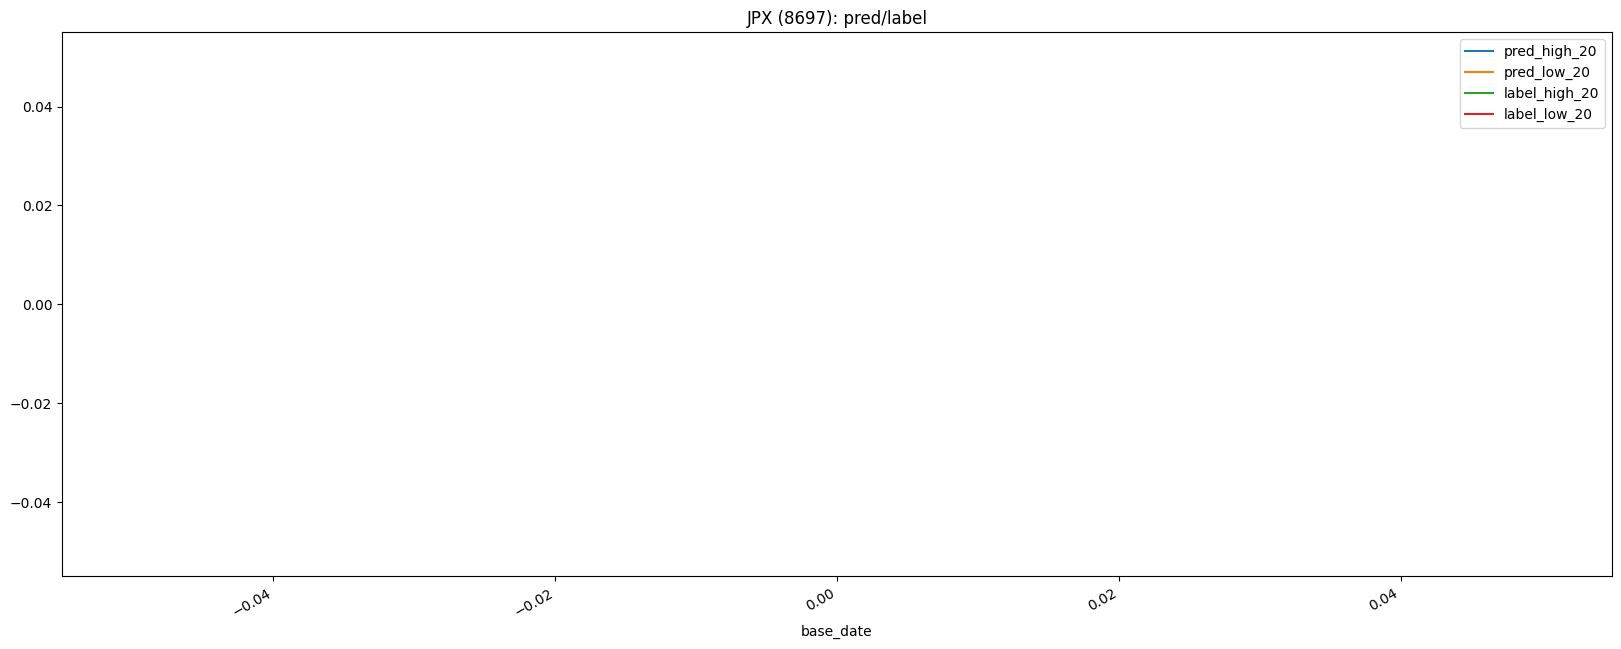

In [ ]:
# JPX (8697) の予測とラベルを描画してみる
df_m.loc[
    (df_m["code"] == 8697) & (df_m["base_date"] >= test_start_dt),
    ["base_date", "pred_high_20", "pred_low_20", "label_high_20", "label_low_20"],
].set_index("base_date").plot(figsize=(20, 8), title="JPX (8697): pred/label")

## 予測の評価

日次で直近n個の予測と正解ラベルとの順位相関を確認します。
簡易化するために pred_high_20 のみを評価しています。

In [2]:
# ラベルの存在する営業日を取得します
dt_list = sorted(stock_labels.loc[stock_labels["label_high_20"].notna(), "base_date"].unique())

NameError: name 'stock_labels' is not defined

In [3]:
# 評価用に日次で直近n個の予測をグループ化します
df_m2 = df_m.sort_values(["base_date", "pred_high_20", "code"])
# label が存在しないレコードを除外
df_m2 = df_m2.loc[df_m2["label_high_20"].notna()]
# グループ化
dfs_ret = {}
for latest_n in [10, 20, 50, 100, 200, 300, 400]:
    buff = []
    for dt in dt_list:
        tmp_df = df_m2.loc[df_m2["base_date"] <= dt].sort_values(["base_date", "pred_high_20", "code"]).tail(latest_n).copy()
        tmp_df["eval_date"] = dt
        buff.append(tmp_df)
    df_ret = pd.concat(buff)
    df_ret.index = df_ret["eval_date"]
    df_ret.index.name = "date"

    # テスト期間に絞り込み
    df_ret = df_ret.loc[df_ret.index >= test_start_dt]
    dfs_ret[latest_n] = df_ret

NameError: name 'df_m' is not defined

In [ ]:
from scipy.stats import spearmanr

def _spearmanr_high_20(df):
    return spearmanr(df["pred_high_20"].values, df["label_high_20"].values)[0]


# def _spearmanr_low_20(df):
#     return spearmanr(df["pred_low_20"].values, df["label_low_20"].values)[0]

In [1]:
for latest_n in [10, 20, 50, 100, 200, 300, 400]:
    display(f"latest_n: {latest_n}")
    # display(dfs_ret[latest_n].groupby("eval_date").apply(_spearmanr).head(2))
    # display(dfs_ret[latest_n].groupby("eval_date").apply(_spearmanr).tail(2))
    display("label_high_20")
    display(dfs_ret[latest_n].groupby("eval_date").apply(_spearmanr_high_20).describe())
    dfs_ret[latest_n].groupby("eval_date").apply(_spearmanr_high_20).plot(figsize=(20, 8), title=f"spearman: label_high_20, latest {latest_n}")
    plt.show()
    dfs_ret[latest_n].groupby("eval_date").apply(_spearmanr_high_20).cumsum().plot(figsize=(20, 8), title=f"cumsum(spearman): label_high_20, latest {latest_n}")
    plt.show()
    # display("label_low_20")  # low側を評価するにはグループ化方法もlowに合わせたもので実施するのがよいです
    # display(dfs_ret[latest_n].groupby("eval_date").apply(_spearmanr_low_20).describe())
    # dfs_ret[latest_n].groupby("eval_date").apply(_spearmanr_low_20).plot(figsize=(20, 8), title=f"spearman: label_low_20, latest {latest_n}")
    # plt.show()
    # dfs_ret[latest_n].groupby("eval_date").apply(_spearmanr_low_20).cumsum().plot(figsize=(20, 8), title=f"cumsum(spearman): label_low_20, latest {latest_n}")
    # plt.show()

'latest_n: 10'

NameError: name 'dfs_ret' is not defined

本ノートブックは以上となります。


用途に合わせて予測対象銘柄やラベルを変更したり、特徴量を変更したりすることで、さまざまな予測を実施することができます。
ぜひいろいろなモデルを作成して評価を実施してみてください。

日本取引所グループで公開されている「[株式分析チュートリアル](https://japanexchangegroup.github.io/J-Quants-Tutorial/)」も大変参考となりますのでぜひ御一読ください。

本ノートブックの作成においてご支援を賜りましたJPX総研のJ-Quants運営チームのみなさま、モデルの移植作業を実施いただいた @akkie30 および本ノートブックへのモデルの移植をご快諾いただいたUKIさん (@blog_uki) に心からの感謝を申し上げます。

本ノートブックがみなさまのモデルを構築する際のご支援となれば幸いでございます。

最後までご覧いただきありがとうございました。